# 03 - Modélisation Credit Risk Scoring
 
**Phase:** 4 - Modélisation ML

---

## Objectifs

1. Charger le dataset de features (`features_v1.csv`)
2. Encoder les variables catégorielles
3. Split train/validation/test (70/15/15)
4. Entraîner un baseline XGBoost
5. Tuner les hyperparamètres avec Optuna
6. Évaluer le modèle final
7. Analyser avec SHAP

**Objectif performance:** AUC-ROC > 0.75

## 1. Setup et Imports

In [1]:
# Core
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, roc_curve, 
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score
)
import xgboost as xgb

# Tuning
import optuna
from optuna.samplers import TPESampler

# Explainability
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import joblib
from pathlib import Path
import json

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)
RANDOM_STATE = 42

print("Imports OK")

Imports OK


## 2. Chargement des données

In [2]:
# Charger le dataset de features
DATA_PATH = Path('../data/features/features_v1.csv')

print(f"Chargement de {DATA_PATH}...")
df = pd.read_csv(DATA_PATH)

print(f"Shape: {df.shape}")
print(f"Mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
df.head()

Chargement de ../data/features/features_v1.csv...
Shape: (307511, 225)
Mémoire: 746.6 MB


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,...,pos_dpd_def_max,pos_dpd_count,pos_dpd_def_count,pos_dpd_ratio,cc_card_count,cc_months_min,cc_months_max,cc_record_count,cc_balance_mean,cc_balance_max,cc_balance_sum,cc_limit_mean,cc_limit_max,cc_drawings_mean,cc_drawings_sum,cc_payment_mean,cc_payment_sum,cc_utilization_mean,cc_utilization_max,cc_over_limit_count,cc_dpd_sum,cc_dpd_mean,cc_dpd_max,cc_dpd_count,cc_payment_to_balance_ratio
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,9.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,-12.0,-10.0,0.0,0.0,0.0,0.0,135000.0,157500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081001
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,9.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,-12.0,-10.0,0.0,0.0,0.0,0.0,135000.0,157500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081001
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,-12.0,-10.0,0.0,0.0,0.0,0.0,135000.0,157500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081001
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,9.0,1,1,0,...,0.0,0.0,0.0,0.0,4.0,-6.0,-6.0,6.0,0.0,0.0,0.0,270000.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,9.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,-12.0,-10.0,0.0,0.0,0.0,0.0,135000.0,157500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081001


In [3]:
# Vérifier la distribution de la cible
print("Distribution TARGET:")
print(df['target'].value_counts())
print(f"\nRatio défaut: {df['target'].mean()*100:.2f}%")
print(f"Ratio classe (neg/pos): {(df['target']==0).sum() / (df['target']==1).sum():.1f}")

Distribution TARGET:
target
0    282686
1     24825
Name: count, dtype: int64

Ratio défaut: 8.07%
Ratio classe (neg/pos): 11.4


## 3. Préparation des données

### 3.1 Identifier les types de colonnes

In [4]:
# Identifier les colonnes par type
id_col = 'sk_id_curr'
target_col = 'target'

# Colonnes catégorielles (type object)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Colonnes numériques
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in [id_col, target_col]]

print(f"ID: {id_col}")
print(f"Target: {target_col}")
print(f"Colonnes catégorielles: {len(cat_cols)}")
print(f"Colonnes numériques: {len(num_cols)}")

if cat_cols:
    print(f"\nCatégorielles: {cat_cols[:10]}..." if len(cat_cols) > 10 else f"\nCatégorielles: {cat_cols}")

ID: sk_id_curr
Target: target
Colonnes catégorielles: 16
Colonnes numériques: 207

Catégorielles: ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'occupation_type']...


### 3.2 Encodage des variables catégorielles

In [5]:
# Cardinalité des variables catégorielles
if cat_cols:
    cardinality = {col: df[col].nunique() for col in cat_cols}
    cardinality_df = pd.DataFrame.from_dict(cardinality, orient='index', columns=['unique_values'])
    cardinality_df = cardinality_df.sort_values('unique_values', ascending=False)
    print("Cardinalité des variables catégorielles:")
    print(cardinality_df)

Cardinalité des variables catégorielles:
                            unique_values
organization_type                      58
occupation_type                        18
name_income_type                        8
name_type_suite                         7
wallsmaterial_mode                      7
weekday_appr_process_start              7
name_family_status                      6
name_housing_type                       6
name_education_type                     5
fondkapremont_mode                      4
housetype_mode                          3
code_gender                             3
flag_own_car                            2
name_contract_type                      2
flag_own_realty                         2
emergencystate_mode                     2


In [6]:
# Encoder les catégorielles avec LabelEncoder
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Gérer les NaN
    df[col] = df[col].fillna('MISSING')
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
print(f"Encodées: {len(cat_cols)} colonnes")

# Vérifier qu'il n'y a plus de colonnes object
remaining_object = df.select_dtypes(include=['object']).columns.tolist()
print(f"Colonnes object restantes: {remaining_object}")

Encodées: 16 colonnes
Colonnes object restantes: []


### 3.3 Préparation X et y

In [7]:
# Séparer features et target
feature_cols = [c for c in df.columns if c not in [id_col, target_col]]

X = df[feature_cols]
y = df[target_col]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Features: {len(feature_cols)}")

X shape: (307511, 223)
y shape: (307511,)
Features: 223


### 3.4 Split Train / Validation / Test

In [8]:
# Split 70% train / 15% validation / 15% test
# Stratified pour garder le ratio de classes

# D'abord: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=RANDOM_STATE,
    stratify=y
)

# Ensuite: 50% val, 50% test (du temp = 15% chacun du total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("Split effectué:")
print(f"  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Valid: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nRatio défaut par set:")
print(f"  Train: {y_train.mean()*100:.2f}%")
print(f"  Valid: {y_val.mean()*100:.2f}%")
print(f"  Test:  {y_test.mean()*100:.2f}%")

Split effectué:
  Train: 215,257 (70.0%)
  Valid: 46,127 (15.0%)
  Test:  46,127 (15.0%)

Ratio défaut par set:
  Train: 8.07%
  Valid: 8.07%
  Test:  8.07%


## 4. Baseline Model

In [9]:
# Calculer scale_pos_weight pour gérer le déséquilibre
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 11.39


In [10]:
# Baseline XGBoost avec paramètres par défaut
baseline_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='auc'
)

print("Entraînement du baseline...")
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("Baseline entraîné!")

Entraînement du baseline...
Baseline entraîné!


In [11]:
# Évaluation baseline sur validation
y_pred_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]
auc_baseline = roc_auc_score(y_val, y_pred_proba_baseline)
gini_baseline = 2 * auc_baseline - 1

print("=" * 40)
print("BASELINE RESULTS (Validation Set)")
print("=" * 40)
print(f"AUC-ROC: {auc_baseline:.4f}")
print(f"Gini:    {gini_baseline:.4f}")

BASELINE RESULTS (Validation Set)
AUC-ROC: 0.7778
Gini:    0.5556


## 5. Hyperparameter Tuning avec Optuna

####  OPTIMISATION HYPERPARAMÈTRES AVEC OPTUNA

**Objectif :** Trouver les meilleurs hyperparamètres pour maximiser l'AUC-ROC                                          
   Plages de recherche (basées sur les bonnes pratiques XGBoost) :                                                    
   - max_depth (3-10) : Profondeur arbres, contrôle overfitting                                                     
   - learning_rate (0.01-0.3) : Vitesse apprentissage, plus bas = plus stable                                       
   - n_estimators (100-1000) : Nombre d'arbres, plus = meilleur mais plus lent                                      
   - min_child_weight (1-10) : Régularisation, évite splits sur peu de données                                      
   - subsample (0.6-1.0) : % lignes par arbre, réduit overfitting                                                   
   - colsample_bytree (0.6-1.0) : % features par arbre, réduit overfitting                                          
   - gamma (0-5) : Seuil minimum de gain pour split                                                                 
   - reg_alpha (0-10) : Régularisation L1 (sparsité)                                                                
   - reg_lambda (0-10) : Régularisation L2 (pénalise grands poids)
         
**Stratégie** : 100 trials avec pruning (arrêt précoce des essais peu prometteurs)                                     
 

In [12]:
def objective(trial):
    """Fonction objectif pour Optuna."""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'auc'
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc

In [13]:
# Lancer l'optimisation Optuna
# Ajuster n_trials selon le temps disponible (100 = ~30-60 min)

N_TRIALS = 50  # Modifier si besoin

print(f"Démarrage Optuna avec {N_TRIALS} trials...")

sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(                                                                                         
    direction='maximize',                                                                                            
    sampler=sampler,                                                                                                 
    storage='sqlite:///../models/optuna_study.db',  # Sauvegarde sur disque                                          
    study_name='credit_risk_xgb',                                                                                    
    load_if_exists=True  # Reprend si crash                                                                          
)

# Callback pour afficher la progression
def print_callback(study, trial):
    if trial.number % 10 == 0:
        print(f"Trial {trial.number}: AUC = {trial.value:.4f} (Best: {study.best_value:.4f})")

study.optimize(objective, n_trials=N_TRIALS, callbacks=[print_callback], show_progress_bar=True)

print("\n" + "=" * 40)
print("OPTUNA TERMINÉ")
print("=" * 40)
print(f"Meilleur AUC: {study.best_value:.4f}")
print(f"Amélioration vs baseline: +{(study.best_value - auc_baseline)*100:.2f}%")

Démarrage Optuna avec 50 trials...


[I 2026-01-27 12:30:58,311] A new study created in RDB with name: credit_risk_xgb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-27 12:31:25,460] Trial 0 finished with value: 0.7598488132122261 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.7598488132122261.
Trial 0: AUC = 0.7598 (Best: 0.7598)
[I 2026-01-27 12:31:37,672] Trial 1 finished with value: 0.7747282209249274 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.7747282209249274.
[I 2026-01-27 12:31:49,870] Trial 2 finished with value: 0.7815473607761322 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.0

In [14]:
# Meilleurs paramètres
print("Meilleurs paramètres:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Meilleurs paramètres:
  n_estimators: 475
  max_depth: 3
  learning_rate: 0.0751903773070408
  min_child_weight: 3
  subsample: 0.7865839636205538
  colsample_bytree: 0.8815254000170597
  gamma: 2.977466836195499
  reg_alpha: 3.7561669875778145
  reg_lambda: 6.390781793902571


## 6. Modèle Final

In [15]:
# Entraîner le modèle final avec les meilleurs paramètres
best_params = study.best_params
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'auc'

final_model = xgb.XGBClassifier(**best_params)

print("Entraînement du modèle final...")
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("Modèle final entraîné!")

Entraînement du modèle final...
Modèle final entraîné!


## 7. Évaluation Finale (Test Set)

In [16]:
# Prédictions sur le test set (jamais vu pendant l'entraînement)
y_pred_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Métriques
auc_test = roc_auc_score(y_test, y_pred_proba_test)
gini_test = 2 * auc_test - 1
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print("=" * 50)
print("RÉSULTATS FINAUX (Test Set - Données jamais vues)")
print("=" * 50)
print(f"AUC-ROC:   {auc_test:.4f}")
print(f"Gini:      {gini_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")
print("=" * 50)

if auc_test >= 0.75:
    print("\n>>> OBJECTIF ATTEINT: AUC > 0.75 <<<")
else:
    print(f"\n>>> Objectif non atteint. Manque: {0.75 - auc_test:.4f} <<<")

RÉSULTATS FINAUX (Test Set - Données jamais vues)
AUC-ROC:   0.7836
Gini:      0.5673
Precision: 0.1862
Recall:    0.6998
F1-Score:  0.2941

>>> OBJECTIF ATTEINT: AUC > 0.75 <<<


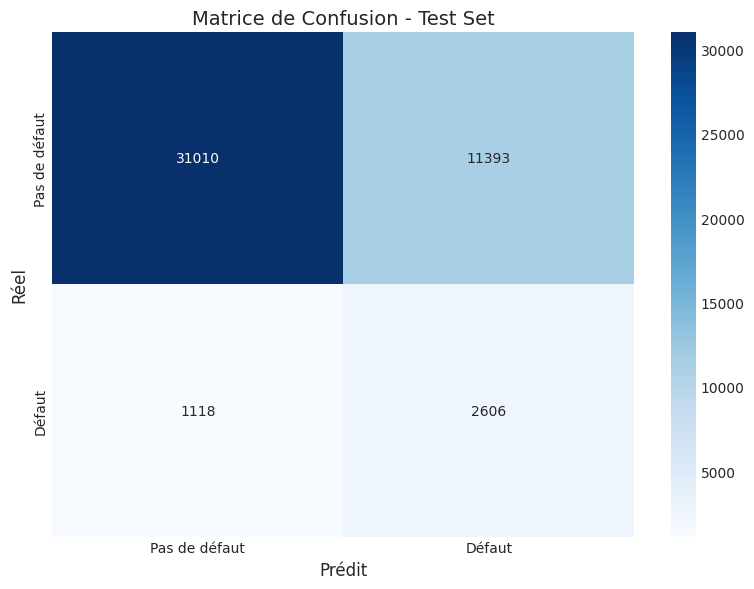


Classification Report:
               precision    recall  f1-score   support

Pas de défaut       0.97      0.73      0.83     42403
       Défaut       0.19      0.70      0.29      3724

     accuracy                           0.73     46127
    macro avg       0.58      0.72      0.56     46127
 weighted avg       0.90      0.73      0.79     46127



In [25]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pas de défaut', 'Défaut'],
            yticklabels=['Pas de défaut', 'Défaut'])
plt.xlabel('Prédit', fontsize=12)
plt.ylabel('Réel', fontsize=12)
plt.title('Matrice de Confusion - Test Set', fontsize=14)
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Pas de défaut', 'Défaut']))

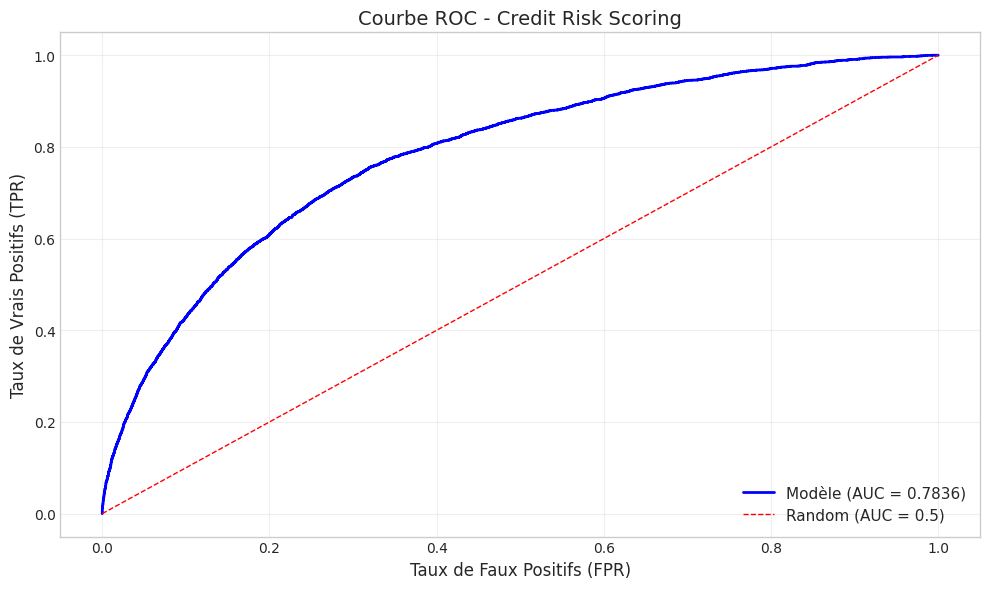

In [26]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'Modèle (AUC = {auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random (AUC = 0.5)')
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC - Credit Risk Scoring', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/roc_curve.png', dpi=150, bbox_inches='tight') 
plt.show()

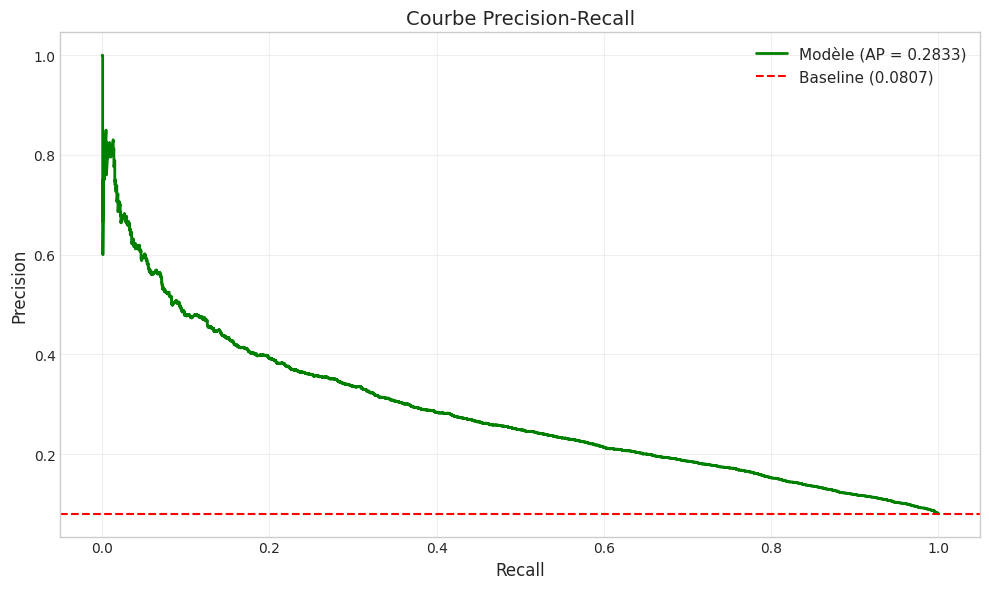

In [27]:
# Courbe Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_test)
ap = average_precision_score(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, 'g-', linewidth=2, label=f'Modèle (AP = {ap:.4f})')                          
plt.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.4f})')                     
plt.xlabel('Recall', fontsize=12)                                                                                    
plt.ylabel('Precision', fontsize=12)                                                                                 
plt.title('Courbe Precision-Recall', fontsize=14)                                                                    
plt.legend(loc='upper right', fontsize=11)                                                                           
plt.grid(True, alpha=0.3)                                                                                            
plt.tight_layout()                                                                                                   
plt.savefig('../models/precision_recall_curve.png', dpi=150, bbox_inches='tight')                                    
plt.show()

## 8. Explicabilité SHAP

In [20]:
# Calculer les SHAP values (peut prendre quelques minutes)
print("Calcul des SHAP values...")

# Utiliser un échantillon pour accélérer
X_sample = X_test.sample(n=min(1000, len(X_test)), random_state=RANDOM_STATE)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sample)

print("SHAP values calculés!")

Calcul des SHAP values...
SHAP values calculés!


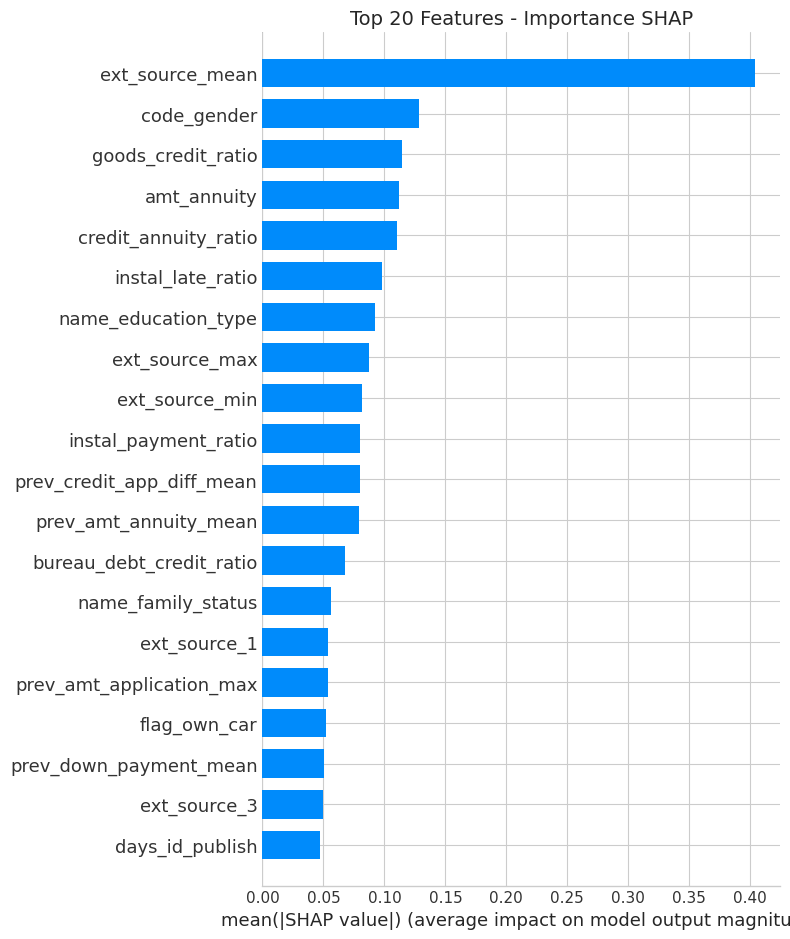

In [23]:
# Feature Importance globale (SHAP)
plt.figure(figsize=(14, 12))  # Plus grand                                                                           
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False, max_display=20)                                
plt.title('Top 20 Features - Importance SHAP', fontsize=14)                                                          
plt.tight_layout()                                                                                                   
plt.savefig('../models/shap_importance.png', dpi=150, bbox_inches='tight')  # Sauvegarde                             
plt.show()

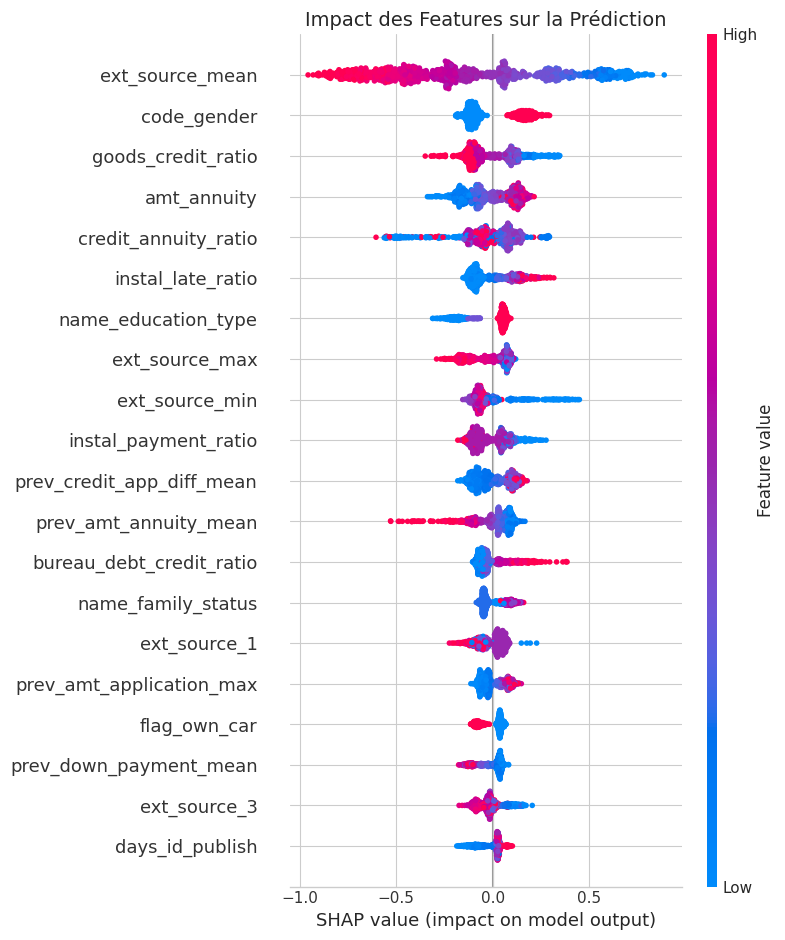

In [24]:
# Summary plot (impact sur la prédiction)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False, max_display=20)
plt.title('Impact des Features sur la Prédiction', fontsize=14)                                                      
plt.tight_layout()                                                                                                   
plt.savefig('../models/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
# Top 10 features les plus importantes
feature_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("Top 10 Features:")
print(feature_importance.head(10).to_string(index=False))

Top 10 Features:
             feature  importance
     ext_source_mean    0.404212
         code_gender    0.128737
  goods_credit_ratio    0.114029
         amt_annuity    0.111660
credit_annuity_ratio    0.109993
   instal_late_ratio    0.097960
 name_education_type    0.092229
      ext_source_max    0.086988
      ext_source_min    0.081797
instal_payment_ratio    0.080330


## 9. Sauvegarde du Modèle

In [29]:
# Créer le dossier models si nécessaire
MODELS_PATH = Path('../models')
MODELS_PATH.mkdir(exist_ok=True)

# Sauvegarder le modèle
model_path = MODELS_PATH / 'xgboost_credit_risk_v1.pkl'
joblib.dump(final_model, model_path)
print(f"Modèle sauvegardé: {model_path}")

# Sauvegarder les noms de features
features_path = MODELS_PATH / 'feature_names.json'
with open(features_path, 'w') as f:
    json.dump(feature_cols, f)
print(f"Features sauvegardées: {features_path}")

# Sauvegarder les label encoders
encoders_path = MODELS_PATH / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"Encoders sauvegardés: {encoders_path}")

# Sauvegarder les métriques
metrics = {
    'auc_roc': float(auc_test),
    'gini': float(gini_test),
    'precision': float(precision_test),
    'recall': float(recall_test),
    'f1_score': float(f1_test),
    'best_params': best_params
}
metrics_path = MODELS_PATH / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2, default=str)
print(f"Métriques sauvegardées: {metrics_path}")

Modèle sauvegardé: ../models/xgboost_credit_risk_v1.pkl
Features sauvegardées: ../models/feature_names.json
Encoders sauvegardés: ../models/label_encoders.pkl
Métriques sauvegardées: ../models/metrics.json


## 10. Résumé

In [31]:
print("=" * 60)
print("RÉSUMÉ - PHASE 4 MODÉLISATION")
print("=" * 60)
print(f"\nDataset: {df.shape[0]:,} lignes × {len(feature_cols)} features")
print(f"\nSplit:")
print(f"  - Train: {len(X_train):,}")
print(f"  - Valid: {len(X_val):,}")
print(f"  - Test:  {len(X_test):,}")
print(f"\nRésultats:")
print(f"  - Baseline AUC: {auc_baseline:.4f}")
print(f"  - Final AUC:    {auc_test:.4f}")
print(f"  - Amélioration: +{(auc_test - auc_baseline)*100:.2f}%")
print(f"\nTop 5 Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")
print(f"\nFichiers sauvegardés:")
print(f"  - {model_path}")
print(f"  - {features_path}")
print(f"  - {encoders_path}")
print(f"  - {metrics_path}")

RÉSUMÉ - PHASE 4 MODÉLISATION

Dataset: 307,511 lignes × 223 features

Split:
  - Train: 215,257
  - Valid: 46,127
  - Test:  46,127

Résultats:
  - Baseline AUC: 0.7778
  - Final AUC:    0.7836
  - Amélioration: +0.58%

Top 5 Features:
  ext_source_mean: 0.4042
  code_gender: 0.1287
  goods_credit_ratio: 0.1140
  amt_annuity: 0.1117
  credit_annuity_ratio: 0.1100

Fichiers sauvegardés:
  - ../models/xgboost_credit_risk_v1.pkl
  - ../models/feature_names.json
  - ../models/label_encoders.pkl
  - ../models/metrics.json
